In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [7]:
def getSubarray(dims, new_dims, offset=[0, 0, 0], spacing=1):

    idx_column = np.arange(0, dims[0], spacing).reshape(-1,1)
    idx_row = np.arange(0, dims[1], spacing)
    idx_freq = np.arange(offset[2], offset[2] + new_dims[2], 1)

    if (len(idx_column) < new_dims[0]) or (len(idx_row) < new_dims[1]):
        print('Problem in finding the subarray')
        exit()
    else:
        idx_column = idx_column[offset[0]:offset[0] + new_dims[0]]

    idx_array = np.zeros((new_dims[0] * new_dims[1], 1), dtype=int)

    for il2 in range(new_dims[1]):
        idx_array[il2 * new_dims[0]:(il2 + 1) * new_dims[0]] = idx_column + dims[0] * (il2 + offset[1]) * spacing

    return idx_array.reshape(-1), idx_freq
    
def delay_response_vector_naive(az, tau, r, f, wave):
    a = np.zeros(r.shape[1], dtype=complex)
    e = np.matrix([np.cos(az), np.sin(az)])

    for i in range(len(a)):
        a[i] = np.exp(2j * np.pi * wave * np.dot(e, r[:, i]))
    
    b = np.zeros(len(f), dtype=complex)
    for i in range(len(b)):
        b[i] = np.exp(-2j * np.pi * f[i] * tau)

    return np.kron(b, a)

def delay_response_vector(az, tau, r, f, wave):
    # Angle
    e = np.matrix([np.cos(az), np.sin(az)])
    a = np.exp(2j * np.pi * (1 / wave) * e @ r).T
    
    # Time delay
    b = np.exp(-2j * np.pi * f * tau)
    
    return np.kron(b, a)

def get_noise(x, SNR_dB=5):
    L, N = x.shape
    SNR = 10.0**(SNR_dB / 10.0) # Desired linear SNR
    xVar = x.var() # Power of signal
    nVar = xVar / SNR # Desired power of noise
    n = np.random.normal(0, np.sqrt(nVar*2.0)/2.0, size=(L, 2*N)).view(complex)
    
    #print('varX = ', xVar, 'varY = ', nVar)
    #print(10*np.log10(xVar / nVar), SNR_dB)
    
    return n

# System parameters
SNR_dB = -10
N_rows = 71
N_cols = 66
array_size = np.array([N_rows, N_cols, 101])

# Subarray
L1 = 10
L2 = 10
L3 = 20
sub_array_size = np.array([L1, L2, L3])
idx_array, idx_n = getSubarray(array_size, sub_array_size, spacing=2)

# Load data
data = loadmat('MeasurementforMiniproject.mat')
#X = data['X_synthetic'][idx_array][:, idx_n]
#X += get_noise(X, SNR_dB)
X = data['X'][idx_array][:, idx_n]
r = data['r'][:, idx_array]
f = data['f'][idx_n]
f0 = data['f0'][0, 0]
tau = data['tau']
true_angles = np.rad2deg(data['smc_param'][0][0][1])
true_angles[true_angles < 0] = true_angles[true_angles < 0] + 360

# Print info
print(f'X: {X.shape}, r: {r.shape}')
print('f:', f.shape)
print('r:', r.shape)
print('Maximum time-delay:', tau[-1] - tau[0])
print('Number of sources:', data['smc_param'][0][0][0])
print('True angles:\n', true_angles)
print('True time-delays:\n', data['smc_param'][0][0][2])

X: (100, 20), r: (2, 100)
f: (20, 1)
r: (2, 100)
Maximum time-delay: [5.e-07]
Number of sources: [[5]]
True angles:
 [[ 50.88252107]
 [ 34.82704776]
 [164.39983394]
 [272.69385129]
 [ 64.56419748]]
True time-delays:
 [[3.23578932]
 [4.39589382]
 [9.33539943]
 [9.35254152]
 [5.7079572 ]]


In [8]:
# Calculated parameters
samples = len(f)
wave = 3e8 / f0
print('Number of samples:', samples)

# Time-delay parameters
K = 100
tau_max = 5e-7
tau_search = np.linspace(start=0, stop=1, num=K, endpoint=True) * tau_max

# AoA parameters
D = 100
az_search = np.linspace(start=0, stop=2*np.pi, num=D, endpoint=True)

# Power spectrum
Pb = np.zeros((K, D), dtype=complex)

X = X.flatten(order='F').reshape(len(X.flatten(order='F')), 1, order='F')
R = X @ X.conj().T

for i in range(D):
    print(i, '/', D)
    for j in range(K):
        
        mu = delay_response_vector(az_search[i], tau_search[j], r, f, wave)
        muH = mu.conj().T

        Pb[j, i] = (muH @ R @ mu) / (np.linalg.norm(mu)**4)


Number of samples: 20
0 / 100
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100


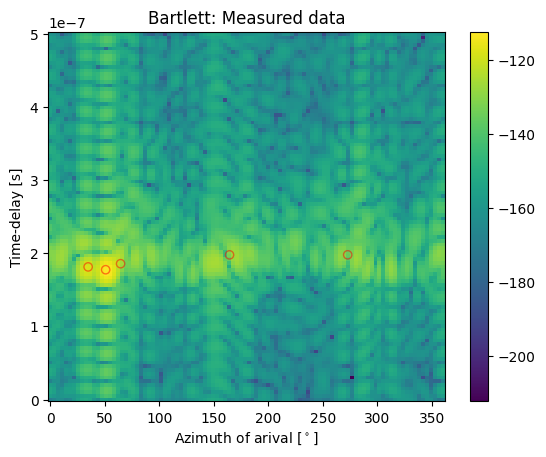

In [10]:
# Plot spectrogram
fig, ax = plt.subplots()
im = ax.pcolormesh(np.rad2deg(az_search), tau_search, 10*np.log10(np.abs(Pb)))
# Plot ground truth
AoA = (data['smc_param'][0][0][1])*180/np.pi
AoA[AoA < 0] = AoA[AoA < 0] + 360
TDoA = (data['smc_param'][0][0][2])*(1/3e8) + np.abs(data['tau'][0])
ax.scatter(AoA, TDoA, color='r', marker='o', facecolors='none', alpha=1/2)
ax.set_xlabel('Azimuth of arival [$^\circ$]')
ax.set_ylabel('Time-delay [s]')
fig.colorbar(im, ax=ax)
ax.set_title('Bartlett: Measured data')
#ax.set_title(f'Bartlett: Simulated data, SNR = {SNR_dB}')
fig.savefig("bartlett_10_10_20_meas.pdf", dpi=100)